In [204]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt # type: ignore

In [205]:
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.1.2+cu118
Numpy version: 1.24.1


##### Make classification data:

In [206]:
from sklearn.datasets import make_circles # type: ignore


# Make 1000 samples 
n_samples = 3000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.04, # a little bit of noise to the dots
                    random_state=47) # keep random state so we get the same values

In [207]:
y = y.reshape(-1, 1)

In [208]:
X.shape, y.shape

((3000, 2), (3000, 1))

In [209]:
df = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1], 'y': y[:, 0]})
df.head()

,x1,x2,y
0,0.247893,-0.788165,1
1,0.961860,0.325725,0
2,-0.077359,-1.066680,0
3,0.402354,0.763478,1
4,0.045377,0.775663,1


In [210]:
df.y.value_counts()

1    1500
0    1500
Name: y, dtype: int64

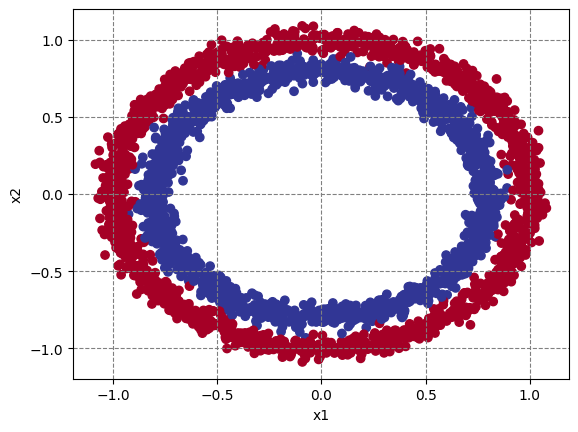

In [211]:
# now, let's plot the data
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

plt.xlabel('x1');
plt.ylabel('x2');

plt.grid(True, linestyle='--', color='gray');

plt.show();

In [212]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [213]:
X.shape, y.shape

(torch.Size([3000, 2]), torch.Size([3000, 1]))

In [214]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train,
                                                    random_state=47) # make the random split reproducible

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2400, 2]),
 torch.Size([600, 2]),
 torch.Size([2400, 1]),
 torch.Size([600, 1]))

##### Building model

In [215]:
from torch import nn

In [216]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [217]:
# let's put all data into cuda
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [218]:
# let's build the model

class CircleModelV0(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        Z1 = self.layer_1(x)
        A1 = Z1
        Z2 = self.layer_2(A1)
        A2 = Z2
        return A2

In [219]:
model_0 = CircleModelV0().to(device)

In [220]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [221]:
model_0(X_train)

tensor([[0.9431],
        [0.1417],
        [0.4045],
        ...,
        [0.3890],
        [0.4319],
        [0.6156]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [222]:
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.0754, -0.4916],
         [ 0.4301,  0.1434],
         [ 0.4731,  0.3078],
         [-0.1298, -0.5261],
         [-0.7059, -0.5713]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.6658, -0.5229,  0.6346, -0.3915,  0.4248], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.4325, -0.0376, -0.3150, -0.0601,  0.1508]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([0.3253], device='cuda:0', requires_grad=True)]

In [223]:
# let's define the loss fn and the optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.001)

In [224]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [225]:
torch.sigmoid(model_0(X_test[:5]))

tensor([[0.6809],
        [0.7234],
        [0.6635],
        [0.7086],
        [0.6489]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [226]:
torch.round(torch.sigmoid(model_0(X_test[:5])))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [227]:
y_pred = torch.round(torch.sigmoid(model_0(X_test)))

correct = torch.eq(y_test, y_pred).sum().item()
correct

292

In [228]:
acc = correct / y_test.shape[0]
acc

0.4866666666666667

In [229]:
y_train = torch.squeeze(y_train)
y_test = torch.squeeze(y_test)

y_train.shape, y_test.shape

(torch.Size([2400]), torch.Size([600]))

In [230]:
# let's define the training loop

def training_loop(X_train, y_train, X_test, y_test, loss_fn, optimizer, n_iterations, model):
    
    # Create empty loss lists to track values
    train_loss_values = []
    test_loss_values = []
    
    # Build training and evaluation loop
    for epoch in range(n_iterations):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train) 
        
        acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

        # Print out what's happening every 10 epochs
        if (epoch % 10 == 0):
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
        
                # Save the loss values (move them to CPU before converting to NumPy)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
    
    return train_loss_values, test_loss_values

In [231]:
n_iterations = 200

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_0.parameters(),
                                    lr=0.01
                                ),
                                n_iterations=n_iterations, 
                                model=model_0)

Epoch: 0 | Loss: 0.73646, Accuracy: 50.38% | Test loss: 0.74040, Test acc: 48.67%

Epoch: 10 | Loss: 0.73186, Accuracy: 50.71% | Test loss: 0.73539, Test acc: 48.67%

Epoch: 20 | Loss: 0.72780, Accuracy: 51.71% | Test loss: 0.73096, Test acc: 50.17%

Epoch: 30 | Loss: 0.72422, Accuracy: 53.58% | Test loss: 0.72702, Test acc: 53.67%

Epoch: 40 | Loss: 0.72105, Accuracy: 55.75% | Test loss: 0.72352, Test acc: 55.50%

Epoch: 50 | Loss: 0.71825, Accuracy: 57.25% | Test loss: 0.72042, Test acc: 56.33%

Epoch: 60 | Loss: 0.71577, Accuracy: 58.50% | Test loss: 0.71766, Test acc: 57.50%

Epoch: 70 | Loss: 0.71357, Accuracy: 58.71% | Test loss: 0.71520, Test acc: 58.17%

Epoch: 80 | Loss: 0.71163, Accuracy: 58.00% | Test loss: 0.71302, Test acc: 58.50%

Epoch: 90 | Loss: 0.70990, Accuracy: 56.67% | Test loss: 0.71107, Test acc: 57.00%

Epoch: 100 | Loss: 0.70837, Accuracy: 55.83% | Test loss: 0.70933, Test acc: 56.00%

Epoch: 110 | Loss: 0.70700, Accuracy: 54.92% | Test loss: 0.70777, Test acc:

In [232]:
def plot_loss_curves(epochs, train_loss_values, test_loss_values):
    # Create a figure with size 6x4 inches
    plt.figure(figsize=(6, 4))
    
    # Plot the training and test loss values
    plt.plot(range(epochs), train_loss_values, label="Train loss")
    plt.plot(range(epochs), test_loss_values, label="Test loss")
    
    # Set the title and labels
    plt.title("Training and Test Loss Curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    # Add a legend
    plt.legend()
    
    # Add a grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

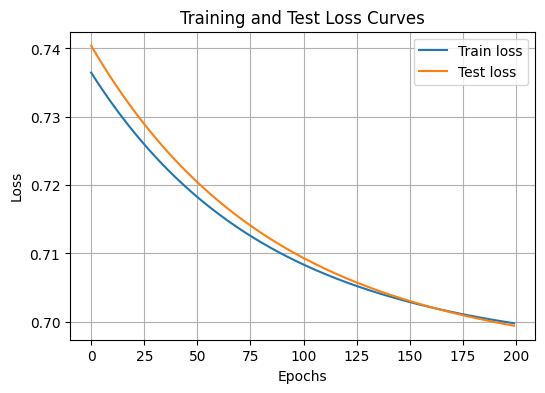

In [233]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [256]:
# let's add non-linearity of the model_0

class CircleModelV1(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # First layer with tanh activation (non-linearity)
        Z1 = self.layer_1(x)
        #A1 = torch.tanh(Z1)
        A1 = torch.relu(Z1)
        
        # Second layer (no activation here, since BCEWithLogitsLoss expects raw logits)
        Z2 = self.layer_2(A1)
        
        return Z2

In [261]:
model_1 = CircleModelV1().to(device)

In [264]:
n_iterations = 2000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_1.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_1)

Epoch: 0 | Loss: 0.68843, Accuracy: 55.71% | Test loss: 0.68904, Test acc: 53.50%

Epoch: 10 | Loss: 0.68802, Accuracy: 55.58% | Test loss: 0.68871, Test acc: 53.33%

Epoch: 20 | Loss: 0.68761, Accuracy: 55.17% | Test loss: 0.68838, Test acc: 53.17%

Epoch: 30 | Loss: 0.68720, Accuracy: 55.42% | Test loss: 0.68805, Test acc: 52.83%

Epoch: 40 | Loss: 0.68680, Accuracy: 55.12% | Test loss: 0.68772, Test acc: 53.17%

Epoch: 50 | Loss: 0.68640, Accuracy: 55.08% | Test loss: 0.68739, Test acc: 53.17%

Epoch: 60 | Loss: 0.68600, Accuracy: 54.87% | Test loss: 0.68706, Test acc: 53.17%

Epoch: 70 | Loss: 0.68560, Accuracy: 54.58% | Test loss: 0.68673, Test acc: 52.83%

Epoch: 80 | Loss: 0.68521, Accuracy: 54.12% | Test loss: 0.68640, Test acc: 52.17%

Epoch: 90 | Loss: 0.68481, Accuracy: 54.12% | Test loss: 0.68606, Test acc: 52.00%

Epoch: 100 | Loss: 0.68442, Accuracy: 54.17% | Test loss: 0.68572, Test acc: 52.17%

Epoch: 110 | Loss: 0.68402, Accuracy: 54.33% | Test loss: 0.68539, Test acc:

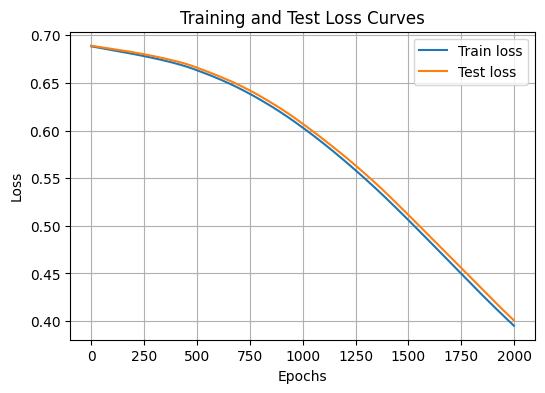

In [265]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [266]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-1.6084, -1.9239],
                      [ 0.2836,  0.3392],
                      [ 1.9463, -1.6570],
                      [-0.0739, -0.0612],
                      [-0.7499,  1.7045],
                      [-0.0612, -0.2612],
                      [-1.8739,  1.1148],
                      [ 1.7274,  1.5699]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.8782, -0.5296, -1.0634, -0.3571, -0.7294, -0.5876, -0.9651, -0.7984],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[-2.5151,  0.2549, -2.6264,  0.1395, -1.8179, -0.1620, -2.3051, -2.3461]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([3.1487], device='cuda:0'))])

In [238]:
from helper_functions import plot_predictions, plot_decision_boundary

In [239]:

def plot_train_test_boundaries(model, X_train, y_train, X_test, y_test):
    """
    Plots decision boundaries for both training and test sets.
    
    Args:
        model: The trained model used for prediction.
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
    """
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot decision boundary for the training set
    plt.subplot(1, 2, 1)
    plt.title("Training Set Decision Boundary")
    plot_decision_boundary(model, X_train, y_train)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Plot decision boundary for the test set
    plt.subplot(1, 2, 2)
    plt.title("Test Set Decision Boundary")
    plot_decision_boundary(model, X_test, y_test)
    plt.xlabel("x1")
    plt.ylabel("x2")

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


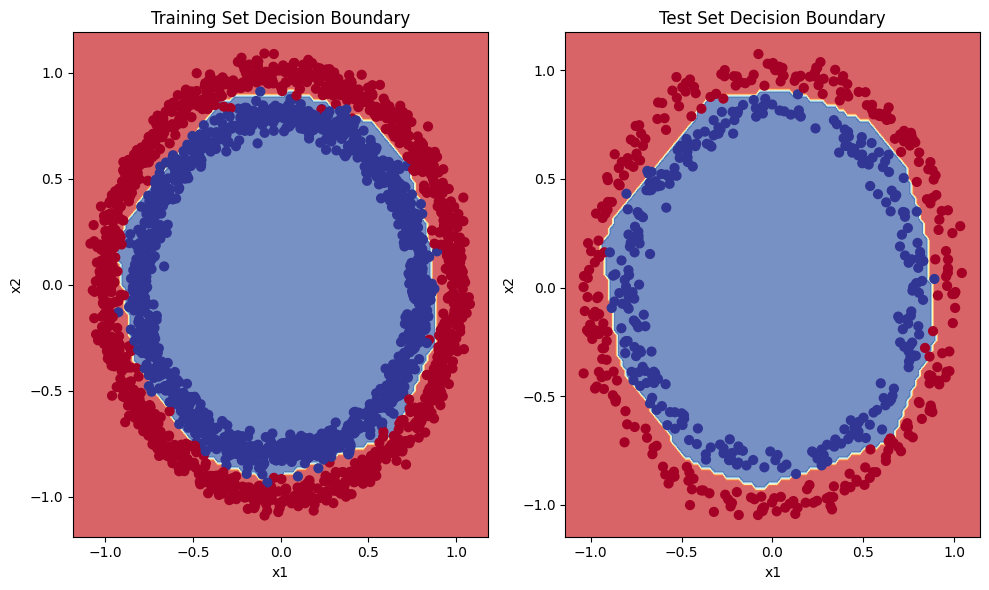

In [260]:
# Example usage
plot_train_test_boundaries(model_1, X_train, y_train, X_test, y_test)

In [241]:

class CircleModelV2(nn.Module):
    
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        # First layer with relu activation (non-linearity)
        Z1 = self.layer_1(x)
        A1 = torch.relu(Z1)
        
        # Second layer with relu activation
        Z2 = self.layer_2(A1)
        A2 = torch.relu(Z2)
        
        # third layer (output layer) (no activation here, since BCEWithLogitsLoss expects raw logits) 
        Z3 = self.layer_3(A2)
        
        return Z3

In [242]:
model_2 = CircleModelV2().to(device)
list(model_2.parameters())

[Parameter containing:
 tensor([[-0.3494,  0.2681],
         [-0.6229, -0.0652],
         [ 0.0696,  0.1311],
         [-0.0628,  0.0517],
         [-0.5412,  0.0917],
         [ 0.1915,  0.2649],
         [ 0.0400, -0.4568],
         [ 0.4442,  0.4676],
         [ 0.2212,  0.1088],
         [ 0.5587,  0.4560],
         [ 0.0591,  0.6357],
         [-0.5621,  0.6445],
         [ 0.6439, -0.2356],
         [-0.3387,  0.5163],
         [-0.0165, -0.5025],
         [-0.5712, -0.3672]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.0008,  0.3966, -0.3811,  0.0370,  0.2921, -0.1746,  0.0326,  0.6104,
         -0.1709,  0.0043,  0.6358, -0.1949, -0.0074,  0.6785,  0.6576,  0.3564],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-1.7018e-01,  1.3792e-02, -1.0759e-01, -2.4958e-01,  1.6993e-02,
          -1.9774e-04,  2.0129e-01, -8.5580e-02, -2.1654e-01,  1.6826e-01,
           1.0567e-01,  5.2231e-02, -8.0312e-02, -2.3724e-01, -1.2036

In [243]:
n_iterations = 1000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_2.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_2)

Epoch: 0 | Loss: 0.69394, Accuracy: 50.33% | Test loss: 0.69676, Test acc: 48.67%

Epoch: 10 | Loss: 0.68959, Accuracy: 50.33% | Test loss: 0.69134, Test acc: 48.67%

Epoch: 20 | Loss: 0.68778, Accuracy: 53.37% | Test loss: 0.68892, Test acc: 52.83%

Epoch: 30 | Loss: 0.68687, Accuracy: 59.58% | Test loss: 0.68764, Test acc: 57.83%

Epoch: 40 | Loss: 0.68626, Accuracy: 63.08% | Test loss: 0.68683, Test acc: 64.17%

Epoch: 50 | Loss: 0.68574, Accuracy: 65.67% | Test loss: 0.68621, Test acc: 64.33%

Epoch: 60 | Loss: 0.68526, Accuracy: 64.75% | Test loss: 0.68569, Test acc: 63.83%

Epoch: 70 | Loss: 0.68477, Accuracy: 62.04% | Test loss: 0.68521, Test acc: 61.17%

Epoch: 80 | Loss: 0.68427, Accuracy: 61.04% | Test loss: 0.68474, Test acc: 60.33%

Epoch: 90 | Loss: 0.68377, Accuracy: 60.75% | Test loss: 0.68424, Test acc: 59.67%

Epoch: 100 | Loss: 0.68324, Accuracy: 60.58% | Test loss: 0.68372, Test acc: 59.67%

Epoch: 110 | Loss: 0.68268, Accuracy: 60.42% | Test loss: 0.68319, Test acc:

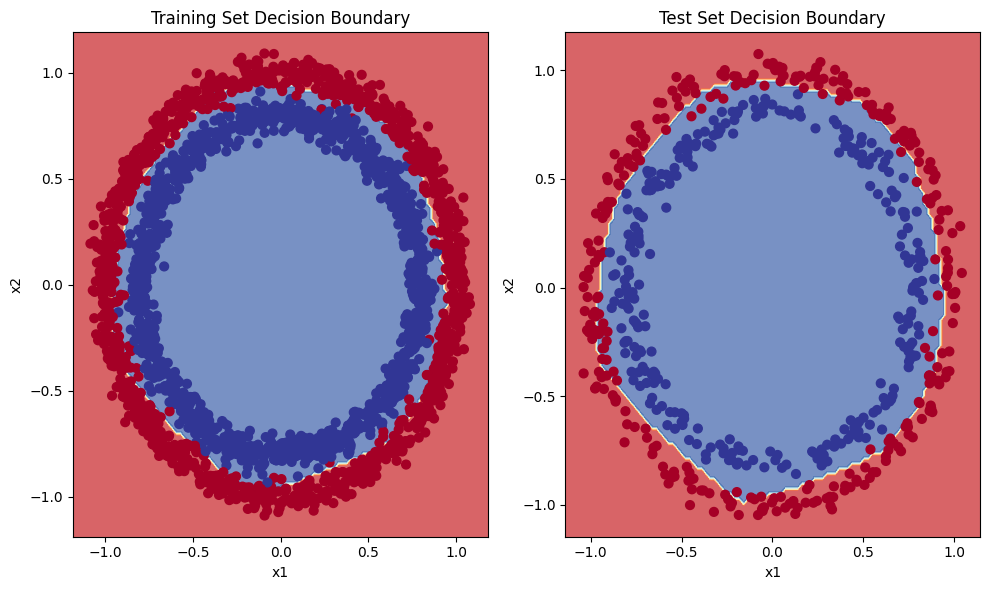

In [244]:
# Example usage
plot_train_test_boundaries(model_2, X_train, y_train, X_test, y_test)

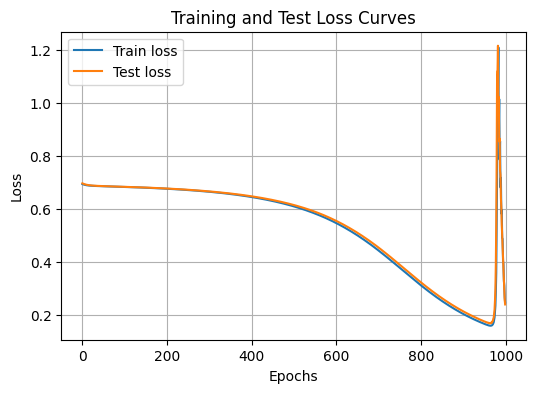

In [245]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [246]:

class CircleModelV3(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        # Define a deeper architecture with more neurons
        self.layer_1 = nn.Linear(in_features=X_train.shape[1], out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        #self.layer_4 = nn.Linear(in_features=16, out_features=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Pass through each layer with ReLU activations
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        # x = self.relu(self.layer_3(x))
        
        # Final layer (logits, no activation as BCEWithLogitsLoss expects raw logits)
        x = self.layer_3(x)
        return x

In [247]:
model_3 = CircleModelV3().to(device)
list(model_3.parameters())

[Parameter containing:
 tensor([[ 0.6897, -0.0875],
         [-0.0496,  0.6427],
         [-0.1964, -0.6283],
         [ 0.0971,  0.5895],
         [-0.2887,  0.5033],
         [-0.3555,  0.0969],
         [-0.5250,  0.5951],
         [-0.6585, -0.5678],
         [-0.3935,  0.6933],
         [-0.6022,  0.4362]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.2068,  0.5524,  0.5974,  0.3529,  0.3689,  0.2840,  0.6462, -0.6705,
          0.4694, -0.2138], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 1.6346e-01, -1.8282e-01,  1.0528e-01,  2.8337e-01, -1.0126e-01,
           1.0427e-01,  5.2505e-02,  1.8506e-01, -1.6936e-01, -2.6530e-01],
         [ 2.3213e-01,  3.0941e-01,  7.1188e-02,  2.4304e-01, -1.2168e-01,
           1.9490e-01,  1.8227e-04,  8.9659e-02,  1.8055e-01, -2.0528e-01],
         [ 2.9930e-01, -8.6734e-02, -8.0031e-02, -1.8055e-01, -2.1000e-01,
           8.1683e-02,  7.5225e-02, -9.8075e-02, -8.2503e-02, -2.4136e-01],
  

In [248]:
n_iterations = 1000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model_3.parameters(),
                                    lr=0.1
                                ),
                                n_iterations=n_iterations, 
                                model=model_3)

Epoch: 0 | Loss: 0.69671, Accuracy: 42.67% | Test loss: 0.69509, Test acc: 44.17%

Epoch: 10 | Loss: 0.69427, Accuracy: 48.71% | Test loss: 0.69376, Test acc: 46.50%

Epoch: 20 | Loss: 0.69295, Accuracy: 49.71% | Test loss: 0.69309, Test acc: 49.50%

Epoch: 30 | Loss: 0.69246, Accuracy: 51.04% | Test loss: 0.69282, Test acc: 51.33%

Epoch: 40 | Loss: 0.69209, Accuracy: 52.21% | Test loss: 0.69253, Test acc: 52.50%

Epoch: 50 | Loss: 0.69177, Accuracy: 52.08% | Test loss: 0.69222, Test acc: 52.17%

Epoch: 60 | Loss: 0.69144, Accuracy: 52.88% | Test loss: 0.69190, Test acc: 53.00%

Epoch: 70 | Loss: 0.69114, Accuracy: 53.04% | Test loss: 0.69158, Test acc: 53.17%

Epoch: 80 | Loss: 0.69084, Accuracy: 53.12% | Test loss: 0.69128, Test acc: 52.83%

Epoch: 90 | Loss: 0.69054, Accuracy: 53.12% | Test loss: 0.69097, Test acc: 53.33%

Epoch: 100 | Loss: 0.69025, Accuracy: 53.46% | Test loss: 0.69066, Test acc: 53.33%

Epoch: 110 | Loss: 0.68994, Accuracy: 53.54% | Test loss: 0.69034, Test acc:

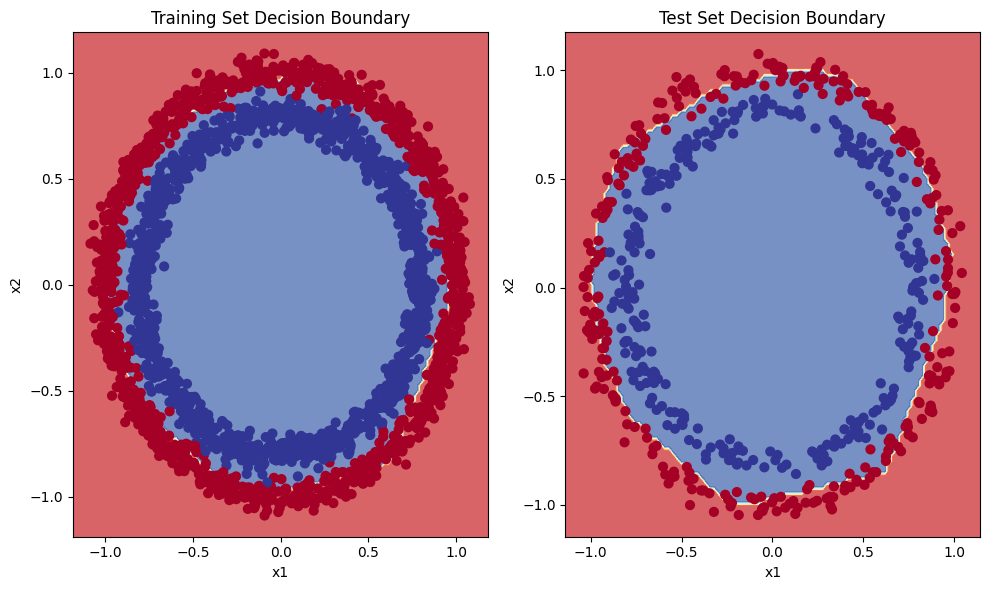

In [249]:
# Example usage
plot_train_test_boundaries(model_3, X_train, y_train, X_test, y_test)

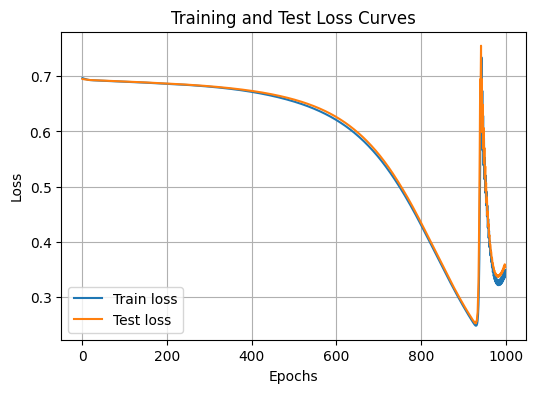

In [250]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)